In [14]:
%matplotlib inline
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf
import numpy as np
import math

In [19]:
model = tf.keras.models.load_model('./models/mnist.h5')
SZ = 28
FZ = 'digits.png'

In [20]:
def drawDigit(position, image, title):
    plt.subplot(*position)
    plt.imshow(image.reshape(-1, 28), cmap='gray_r')
    plt.axis('off')
    plt.title(title)
    
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [23]:
def detect(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # 显示用图片
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #处理用灰度图片
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 10)
    bin = cv2.medianBlur(bin, 3)

    # Threshold the image
    ret, im_th = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the image
    ctrs, heirs = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    try:
        heirs = heirs[0]
    except:
        heirs = []

    bin_set = []
    positions = []
    for cnt, heir in zip(ctrs, heirs):
        _, _, _, outer_i = heir
        if outer_i >= 0:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if not (16 <= h <= 128  and w <= 1.2*h):
            continue
            
        pad = max(h-w, 0) * 1.1
        x, w = math.floor(x - (pad // 2)), math.ceil(w + pad)
        y, h = math.floor(y - (pad // 2)), math.ceil(h + pad)
        
        # Draw the rectangles
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

        bin_roi = bin[y:,x:][:h,:w]

        m = bin_roi != 0
        if not 0.1 < m.mean() < 0.4:
            continue

        s = 1.5*float(h)/SZ
        m = cv2.moments(bin_roi)
        c1 = np.float32([m['m10'], m['m01']]) / m['m00']
        c0 = np.float32([SZ/2, SZ/2])
        t = c1 - s*c0
        A = np.zeros((2, 3), np.float32)
        A[:,:2] = np.eye(2)*s
        A[:,2] = t
        bin_norm = cv2.warpAffine(bin_roi, A, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
        bin_norm = deskew(bin_norm)

        if x+w+SZ < frame.shape[1] and y+SZ < frame.shape[0]:
            img[y:,x+w:][:SZ, :SZ] = bin_norm[...,np.newaxis]
            positions.append((x, y))
            bin_set.append(np.copy(bin_norm))

    #     
    bin_norms = np.array(bin_set)
    predictions = model.predict(bin_norms)

    plt.figure(figsize=(28, bin_norms.shape[0]*28))
    index = 0
    ax = []
    for d_img in bin_norms:
        title = 'actual:%d' %(np.argmax(predictions[index]))
        drawDigit((1, 10, index+1), d_img, title)
        index += 1

    index = 0
    for pt in positions:
        cv2.putText(img, '%d'% (np.argmax(predictions[index])), pt, cv2.FONT_HERSHEY_PLAIN, 2.0, (255, 255, 0), 3)
        index += 1


    plt.figure(figsize=(15,20))
    plt.imshow(img)

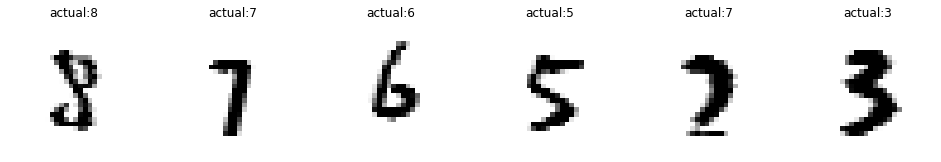

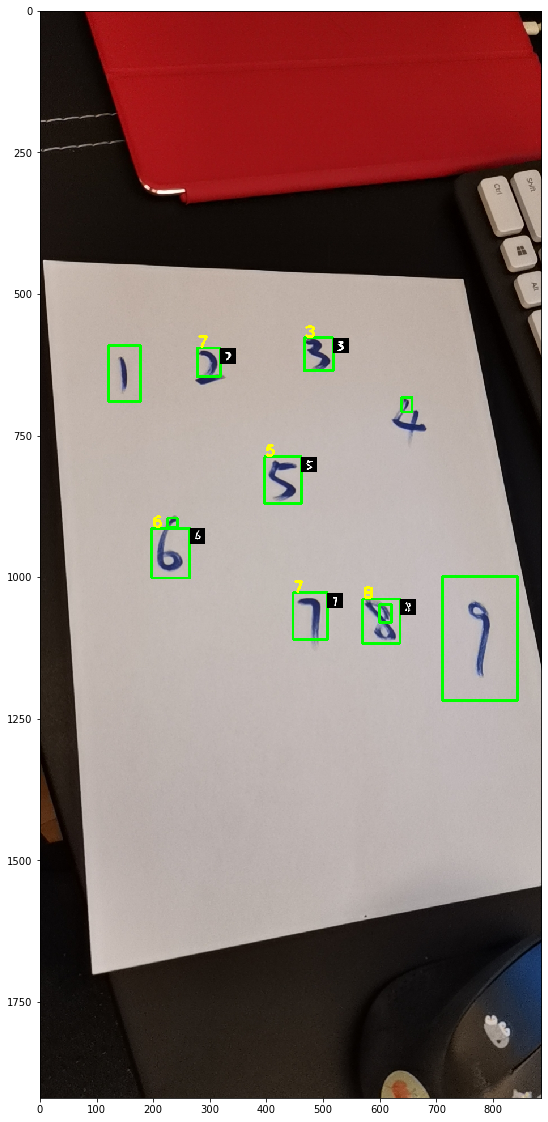

In [24]:
frame = cv2.imread(FZ) #读入原始图片
detect(frame)